In [151]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import shap

In [2]:
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 

In [3]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast

In [4]:
def prepare_data(df):
    x1, x2, x3, x4, x5, x6, target = df['1_week_ago'], df['2_week_ago'], df['3_week_ago'], df['4_week_ago'], df['weeks_since_release'], df['avg_claim_last_month'], df['this_week']
    x1, x2, x3, x4, x5, x6, target = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6), np.array(target)
    x1, x2, x3, x4, x5, x6, target = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1), target.reshape(-1, 1)
    features = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
    
    return features, target

In [5]:
iphone12_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone12_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone13_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone13_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone14_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone14_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/time_series_ML_features_final.csv', parse_dates=['weeks_monday','month_year'])
iphone12 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 12')]
iphone13 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 13')]
iphone14 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 14')]

In [6]:
iphone13_df.drop(['month_year', 'holiday'], axis=1, inplace=True)
iphone14_df.drop(['month_year', 'holiday'], axis=1, inplace=True)

In [9]:
iphone13 = iphone13[(iphone13['weeks_monday'] >= '2021-11-22')] 
iphone13_beg = iphone13.copy().reset_index()
iphone13_beg = iphone13_beg.head(13)
days_since_iphone14_release = iphone13_beg['days_since_release_date'] + 30
iphone13_beg['days_since_release_date'] = days_since_iphone14_release
iphone13_beg['weeks_since_release'] = days_since_iphone14_release // 7 
iphone13_beg['weeks_monday'] = iphone13_beg['weeks_monday'] - pd.Timedelta(days=8)
iphone13_beg['month'] = iphone13_beg['weeks_monday'].dt.month
iphone13_beg['year'] = iphone13_beg['weeks_monday'].dt.year
iphone13_beg['weeks_since_release'] = iphone13_beg['days_since_release_date'].floordiv(7)
iphone13_beg

,index,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
0,60,apple iphone 13,2021-11-14,11,2021,2021-11-01,59,3,8
1,64,apple iphone 13,2021-11-21,11,2021,2021-11-01,66,6,9
2,66,apple iphone 13,2021-11-28,11,2021,2021-12-01,73,2,10
3,69,apple iphone 13,2021-12-05,12,2021,2021-12-01,80,10,11
4,76,apple iphone 13,2021-12-12,12,2021,2021-12-01,87,6,12
5,77,apple iphone 13,2021-12-19,12,2021,2021-12-01,94,15,13
6,83,apple iphone 13,2021-12-26,12,2021,2022-01-01,101,7,14
7,85,apple iphone 13,2022-01-02,1,2022,2022-01-01,108,13,15
8,89,apple iphone 13,2022-01-09,1,2022,2022-01-01,115,10,16
9,96,apple iphone 13,2022-01-16,1,2022,2022-01-01,122,11,17


In [11]:
iphone14 = iphone14.copy()
iphone14['weeks_since_release'] = iphone14['days_since_release_date'].floordiv(7)
iphone14

,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
262,apple iphone 14,2022-11-14,11,2022,2022-11-01,59,9,8
267,apple iphone 14,2022-11-21,11,2022,2022-11-01,66,30,9
271,apple iphone 14,2022-11-28,11,2022,2022-11-01,73,23,10
277,apple iphone 14,2022-12-05,12,2022,2022-12-01,80,43,11
283,apple iphone 14,2022-12-12,12,2022,2022-12-01,87,32,12
289,apple iphone 14,2022-12-19,12,2022,2022-12-01,94,36,13
292,apple iphone 14,2022-12-26,12,2022,2022-12-01,101,44,14
299,apple iphone 14,2023-01-02,1,2023,2023-01-01,108,45,15
303,apple iphone 14,2023-01-09,1,2023,2023-01-01,115,59,16
308,apple iphone 14,2023-01-16,1,2023,2023-01-01,122,60,17


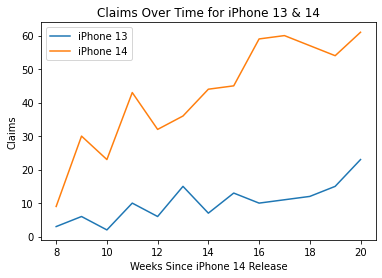

In [12]:
plt.plot(iphone13_beg['weeks_since_release'], iphone13_beg['claim'], label='iPhone 13')
plt.plot(iphone14['weeks_since_release'], iphone14['claim'], label='iPhone 14')

plt.xlabel('Weeks Since iPhone 14 Release')
plt.ylabel('Claims') 
plt.title('Claims Over Time for iPhone 13 & 14')
plt.legend()
plt.show()

In [123]:
iphone13 = iphone13[(iphone13['weeks_monday'] >= '2021-11-22')] 
iphone13_all = iphone13.copy().reset_index()
days_since_iphone14_release = iphone13_all['days_since_release_date'] + 30
iphone13_all['days_since_release_date'] = days_since_iphone14_release
iphone13_all['weeks_since_release'] = days_since_iphone14_release // 7 
iphone13_all['weeks_monday'] = iphone13_all['weeks_monday'] - pd.Timedelta(days=8)
iphone13_all['month'] = iphone13_all['weeks_monday'].dt.month
iphone13_all['year'] = iphone13_beg['weeks_monday'].dt.year
iphone13_all['weeks_since_release'] = iphone13_all['days_since_release_date'].floordiv(7)

In [127]:
iphone13_all = iphone13_all[(iphone13_all['weeks_monday'] <= '2022-03-27')] 

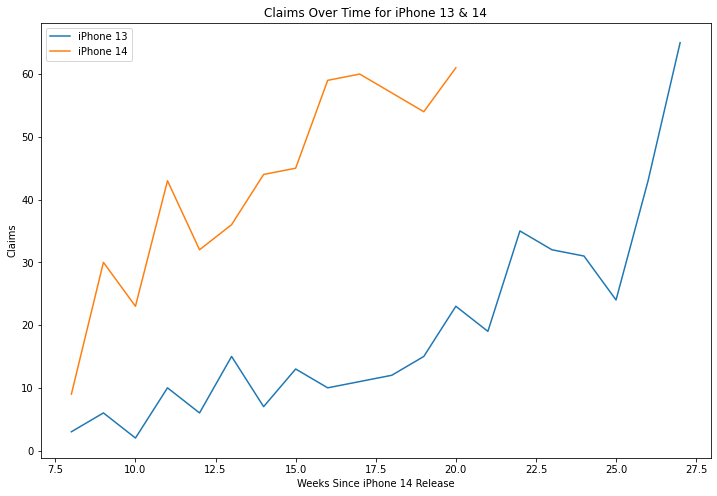

In [128]:
plt.plot(iphone13_all['weeks_since_release'], iphone13_all['claim'], label='iPhone 13')
plt.plot(iphone14['weeks_since_release'], iphone14['claim'], label='iPhone 14')

plt.xlabel('Weeks Since iPhone 14 Release')
plt.ylabel('Claims') 
plt.title('Claims Over Time for iPhone 13 & 14')
plt.legend()
plt.show()

In [13]:
iphone14_avg_claim_per_month = iphone14.groupby('month')['claim'].mean().reset_index()
iphone14_avg_claim_per_month

,month,claim
0,1,55.000000
1,2,61.000000
2,11,20.666667
3,12,38.750000


In [14]:
iphone13_avg_claim_per_month = iphone13_beg.groupby('month')['claim'].mean().reset_index()
iphone13_avg_claim_per_month

,month,claim
0,1,12.200000
1,2,23.000000
2,11,3.666667
3,12,9.500000


In [15]:
merged_df = pd.merge(iphone14_avg_claim_per_month, iphone13_avg_claim_per_month, on='month', suffixes=('_14', '_13'))
merged_df['diff'] = merged_df['claim_14'] - merged_df['claim_13']
diff_by_month = merged_df[['month', 'diff']]
diff_by_month

,month,diff
0,1,42.80
1,2,38.00
2,11,17.00
3,12,29.25


In [17]:
new_iphone13 = iphone13_df.iloc[1:].copy()
days_since_iphone14_release = iphone13_df['days_since_release_date'] + 30 
new_iphone13['days_since_release_date'] = days_since_iphone14_release
new_iphone13['weeks_since_release'] = days_since_iphone14_release // 7 
new_iphone13['weeks_monday'] = iphone13_df['weeks_monday'] - pd.Timedelta(days=8)
new_iphone13['month'] = new_iphone13['weeks_monday'].dt.month
new_iphone13['year'] = new_iphone13['weeks_monday'].dt.year
new_iphone13

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
1,87,2021-12-12,12,2021,6,8.25,3.666667,10.0,2.0,6.0,3.0,12
2,94,2021-12-19,12,2021,15,8.25,3.666667,6.0,10.0,2.0,6.0,13
3,101,2021-12-26,12,2021,7,10.60,8.250000,15.0,6.0,10.0,2.0,14
4,108,2022-01-02,1,2022,13,10.60,8.250000,7.0,15.0,6.0,10.0,15
5,115,2022-01-09,1,2022,10,10.60,8.250000,13.0,7.0,15.0,6.0,16
6,122,2022-01-16,1,2022,11,10.60,8.250000,10.0,13.0,7.0,15.0,17
7,129,2022-01-23,1,2022,12,10.60,8.250000,11.0,10.0,13.0,7.0,18
8,136,2022-01-30,1,2022,15,23.00,10.600000,12.0,11.0,10.0,13.0,19
9,143,2022-02-06,2,2022,23,23.00,10.600000,15.0,12.0,11.0,10.0,20
10,150,2022-02-13,2,2022,19,23.00,10.600000,23.0,15.0,12.0,11.0,21


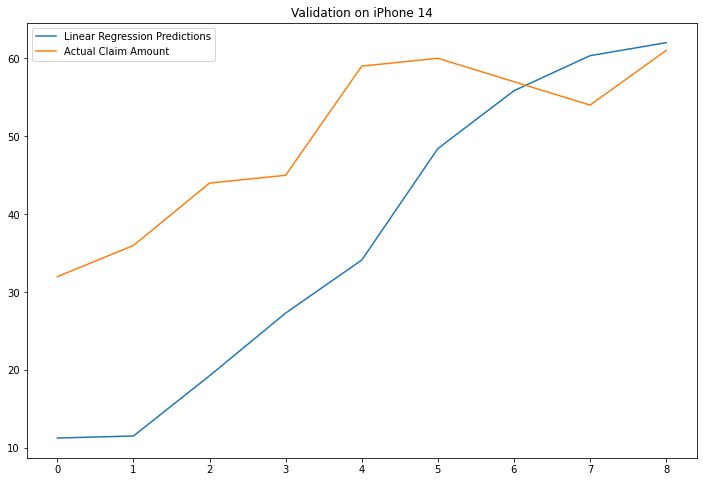

Root Mean sqaured error for Linear Regression model is:  17.459563453845078
WMAPE: 29.57%


In [149]:
iphone13_train = new_iphone13[(new_iphone13['weeks_monday'] <= '2022-11-20')] 
X_train, y_train = prepare_data(iphone13_train)

X_validate, y_validate = prepare_data(iphone14_df)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_validate)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(lin_pred, label = "Linear Regression Predictions")
plt.plot(y_validate, label = "Actual Claim Amount")
plt.title("Validation on iPhone 14")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_validate))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_validate_series = pd.Series(y_validate.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_validate_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

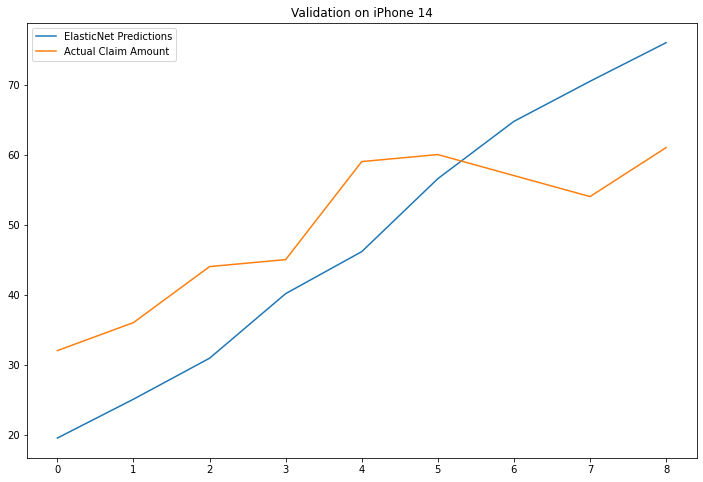

Root Mean sqaured error for ElasticNet model is:  11.564358211228535
WMAPE: 21.63%


In [148]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

iphone13_train = new_iphone13[(new_iphone13['weeks_monday'] <= '2022-11-20')] 
X_train, y_train = prepare_data(iphone13_train)

X_validate, y_validate = prepare_data(iphone14_df)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

enet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
enet_model.fit(X_train_scaled, y_train)
enet_pred = enet_model.predict(X_validate_scaled)

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(enet_pred, label = "ElasticNet Predictions")
plt.plot(y_validate, label = "Actual Claim Amount")
plt.title("Validation on iPhone 14")
plt.legend(loc="upper left")
plt.show()

rmse_enet = sqrt(mean_squared_error(enet_pred, y_validate))
print("Root Mean sqaured error for ElasticNet model is: ", rmse_enet)

y_validate_series = pd.Series(y_validate.ravel())
enet_pred_series = pd.Series(enet_pred.ravel())
wmape_score = wmape(y_validate_series, enet_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))


In [140]:
y_validate

array([[32],
       [36],
       [44],
       [45],
       [59],
       [60],
       [57],
       [54],
       [61]])

In [141]:
lin_pred

array([[11.30276598],
       [11.56438416],
       [19.29244031],
       [27.32941153],
       [34.12549373],
       [48.41852441],
       [55.83911968],
       [60.33366347],
       [62.00230207]])

In [142]:
y_validate - lin_pred

array([[20.69723402],
       [24.43561584],
       [24.70755969],
       [17.67058847],
       [24.87450627],
       [11.58147559],
       [ 1.16088032],
       [-6.33366347],
       [-1.00230207]])

In [143]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,35.50,55.000000,54.0,57.0,60.0,59.0,20


In [133]:
iphone14

,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
262,apple iphone 14,2022-11-14,11,2022,2022-11-01,59,9,8
267,apple iphone 14,2022-11-21,11,2022,2022-11-01,66,30,9
271,apple iphone 14,2022-11-28,11,2022,2022-11-01,73,23,10
277,apple iphone 14,2022-12-05,12,2022,2022-12-01,80,43,11
283,apple iphone 14,2022-12-12,12,2022,2022-12-01,87,32,12
289,apple iphone 14,2022-12-19,12,2022,2022-12-01,94,36,13
292,apple iphone 14,2022-12-26,12,2022,2022-12-01,101,44,14
299,apple iphone 14,2023-01-02,1,2023,2023-01-01,108,45,15
303,apple iphone 14,2023-01-09,1,2023,2023-01-01,115,59,16
308,apple iphone 14,2023-01-16,1,2023,2023-01-01,122,60,17


In [95]:
def predict_next_claim_amount(df, weeks_this_month, growth_init, loss):
    growth_adjustment = growth_init
    
    for i in range(weeks_this_month): 
        x1 = df.iloc[-1]['this_week']
        x2 = df.iloc[-1]['1_week_ago']
        x3 = df.iloc[-1]['2_week_ago']
        x4 = df.iloc[-1]['3_week_ago']
        days = int(df.iloc[-1]['days_since_release_date']) + 7
        x5 = days // 7 
        x6 = df.iloc[-1]['avg_claim_this_month']

        x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
        x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
        X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
        next_pred = lin_model.predict(X_next).item()
        
        if i > 0:
            growth_adjustment *= (1 - loss)
            
        next_pred += growth_adjustment

        new_row = {
            'this_week': next_pred,
            '1_week_ago': x1.item(),
            '2_week_ago': x2.item(),
            '3_week_ago': x3.item(),
            '4_week_ago': x4.item(),
            'weeks_since_release': x5.item(),
            'days_since_release_date': days, 
            'avg_claim_last_month': x6.item(),
            'avg_claim_this_month': x6.item()
        }

        df = df.append(new_row, ignore_index=True)

    rolling_avg = df['this_week'].rolling(weeks_this_month).mean().iloc[-1]
    df.iloc[-weeks_this_month:, df.columns.get_loc('avg_claim_this_month')] = rolling_avg
    return df
# def predict_next_claim_amount(df, weeks_this_month, growth_adjustment):
#     orig_len = len(df)
#     for i in range(weeks_this_month): 
#         x1 = df.iloc[-1]['this_week']
#         x2 = df.iloc[-1]['1_week_ago']
#         x3 = df.iloc[-1]['2_week_ago']
#         x4 = df.iloc[-1]['3_week_ago']
#         days = int(df.iloc[-1]['days_since_release_date']) + 7
#         x5 = days // 7 
#         x6 = df.iloc[-1]['avg_claim_this_month']

#         x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
#         x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
#         X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
#         next_pred = lin_model.predict(X_next).item()

#         new_row = {
#             'this_week': next_pred,
#             '1_week_ago': x1.item(),
#             '2_week_ago': x2.item(),
#             '3_week_ago': x3.item(),
#             '4_week_ago': x4.item(),
#             'weeks_since_release': x5.item(),
#             'days_since_release_date': days, 
#             'avg_claim_last_month': x6.item(),
#             'avg_claim_this_month': x6.item()
#         }

#         df = df.append(new_row, ignore_index=True)

#     df.iloc[orig_len:, df.columns.get_loc('this_week')] += growth_adjustment
#     if weeks_this_month >= 1:
#         df.iloc[orig_len + 1:, df.columns.get_loc('1_week_ago')] += growth_adjustment
#     if weeks_this_month >= 3:
#         df.iloc[orig_len + 2:, df.columns.get_loc('2_week_ago')] += growth_adjustment
#     if weeks_this_month >= 4:
#         df.iloc[orig_len + 3:, df.columns.get_loc('3_week_ago')] += growth_adjustment
#     if weeks_this_month >= 5:
#         df.iloc[orig_len + 4:, df.columns.get_loc('4_week_ago')] += growth_adjustment
#     rolling_avg = df['this_week'].rolling(weeks_this_month).mean().iloc[-1]
#     df.iloc[-weeks_this_month:, df.columns.get_loc('avg_claim_this_month')] = rolling_avg

#     return df

My Predictions:
[48.32941153 50.84638596 54.17466762 58.79097218 65.0235805 ]
Actual:
[45 59 60 57 54]


My Prediction Avg claim this month:55.4330035595126
Actual Avg claim this month: 55.0


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


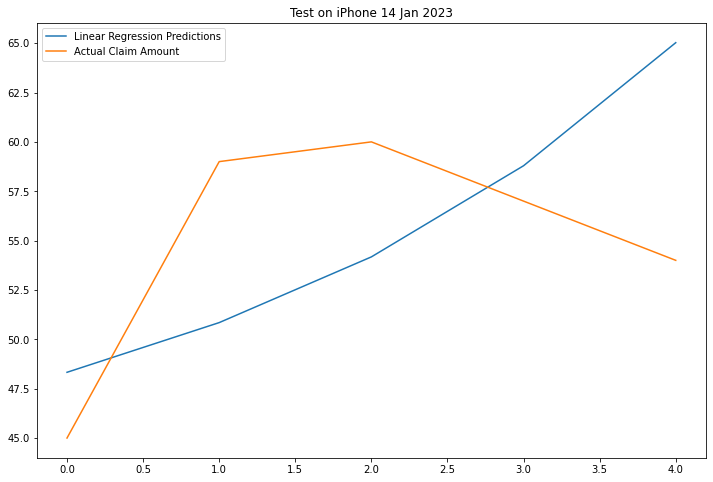

Root Mean sqaured error for Linear Regression model is:  6.873540701713508
WMAPE: 10.95%


In [103]:
weeks_in_Jan23 = 5
iPhone14_predict_Jan23 = iphone14_df.iloc[:3].copy()
iPhone14_predict_Jan23 = predict_next_claim_amount(iPhone14_predict_Jan23, weeks_in_Jan23, 21, 0.3)

my_pred = iPhone14_predict_Jan23['this_week'].tail(weeks_in_Jan23).to_numpy()
print("My Predictions:")
print(my_pred)

truth = np.array(iphone14_df.iloc[3:8]['this_week'].values)
print("Actual:")
print(truth)

print("\n")

my_pred_avg_claim_this_month = iPhone14_predict_Jan23.iloc[-1]['avg_claim_this_month']
print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))

actual_avg_claim_this_month = iphone14_df.iloc[3]['avg_claim_this_month']
print("Actual Avg claim this month: " + str(actual_avg_claim_this_month))

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(my_pred, label = "Linear Regression Predictions")
plt.plot(truth, label = "Actual Claim Amount")
plt.title("Test on iPhone 14 Jan 2023")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(my_pred, truth))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

truth_series = pd.Series(truth.ravel())
my_pred_series = pd.Series(my_pred.ravel())
wmape_score = wmape(truth_series, my_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [153]:
weeks_in_Feb23 = 4
iPhone14_predict_Feb23 = iphone14_df.iloc[:-1].copy()
iPhone14_predict_Feb23 = predict_next_claim_amount(iPhone14_predict_Feb23, weeks_in_Feb23, 20, 0.3)

my_pred = iPhone14_predict_Feb23['this_week'].tail(weeks_in_Feb23).to_numpy()
print("My Predictions:")
print(my_pred)


print("\n")
 
my_pred_avg_claim_this_month = iPhone14_predict_Feb23.iloc[-1]['avg_claim_this_month']
print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))


iPhone14_predict_Feb23


My Predictions:
[ 82.00230207  97.27568979 110.45825746 124.85286225]


My Prediction Avg claim this month:103.64727789310322


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87.0,2022-12-12,12.0,2022.0,32.000000,38.750000,20.666667,43.000000,23.000000,30.000000,9.0,12.0
1,94.0,2022-12-19,12.0,2022.0,36.000000,38.750000,20.666667,32.000000,43.000000,23.000000,30.0,13.0
2,101.0,2022-12-26,12.0,2022.0,44.000000,38.750000,20.666667,36.000000,32.000000,43.000000,23.0,14.0
3,108.0,2023-01-02,1.0,2023.0,45.000000,55.000000,38.750000,44.000000,36.000000,32.000000,43.0,15.0
4,115.0,2023-01-09,1.0,2023.0,59.000000,55.000000,38.750000,45.000000,44.000000,36.000000,32.0,16.0
5,122.0,2023-01-16,1.0,2023.0,60.000000,55.000000,38.750000,59.000000,45.000000,44.000000,36.0,17.0
6,129.0,2023-01-23,1.0,2023.0,57.000000,55.000000,38.750000,60.000000,59.000000,45.000000,44.0,18.0
7,136.0,2023-01-30,1.0,2023.0,54.000000,55.000000,38.750000,57.000000,60.000000,59.000000,45.0,19.0
8,143.0,NaT,NaN,NaN,82.002302,103.647278,55.000000,54.000000,57.000000,60.000000,59.0,20.0
9,150.0,NaT,NaN,NaN,97.275690,103.647278,55.000000,82.002302,54.000000,57.000000,60.0,21.0


In [115]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,35.50,55.000000,54.0,57.0,60.0,59.0,20


In [113]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,35.50,55.000000,54.0,57.0,60.0,59.0,20


In [129]:
new_iphone13

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
1,87,2021-12-12,12,2021,6,8.25,3.666667,10.0,2.0,6.0,3.0,12
2,94,2021-12-19,12,2021,15,8.25,3.666667,6.0,10.0,2.0,6.0,13
3,101,2021-12-26,12,2021,7,10.60,8.250000,15.0,6.0,10.0,2.0,14
4,108,2022-01-02,1,2022,13,10.60,8.250000,7.0,15.0,6.0,10.0,15
5,115,2022-01-09,1,2022,10,10.60,8.250000,13.0,7.0,15.0,6.0,16
6,122,2022-01-16,1,2022,11,10.60,8.250000,10.0,13.0,7.0,15.0,17
7,129,2022-01-23,1,2022,12,10.60,8.250000,11.0,10.0,13.0,7.0,18
8,136,2022-01-30,1,2022,15,23.00,10.600000,12.0,11.0,10.0,13.0,19
9,143,2022-02-06,2,2022,23,23.00,10.600000,15.0,12.0,11.0,10.0,20
10,150,2022-02-13,2,2022,19,23.00,10.600000,23.0,15.0,12.0,11.0,21


In [110]:
x1 = 43
x2 = 23
x3 = 30
x4 = 9
x5 = 12
x6 = 20.67
x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
Dec_12_22_pred = lin_model.predict(X_next)
Dec_12_22_pred += 30

# x1 = Dec_12_22_pred
# x2 = 43
# x3 = 23
# x4 = 30
# x5 = 13 
# x6 = 20.67
# x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
# x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
# X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
# Dec_19_22_pred = lin_model.predict(X_next)
# Dec_19_22_pred 


iPhone14_predict_Dec23 = pd.DataFrame(columns=iphone14_df.columns)

new_row = {
            'this_week': Dec_12_22_pred.item(),
            '1_week_ago': x1.item(),
            '2_week_ago': x2.item(),
            '3_week_ago': x3.item(),
            '4_week_ago': x4.item(),
            'days_since_release_date': 87,
            'weeks_since_release': x5.item(),
            'avg_claim_last_month': x6.item(),
            'avg_claim_this_month': x6.item()
        }
iPhone14_predict_Dec23 = iPhone14_predict_Dec23.append(new_row, ignore_index=True)

iPhone14_predict_Dec23 = predict_next_claim_amount(iPhone14_predict_Dec23, 2, 27, 0.1)
iPhone14_predict_Dec23
# my_pred = iPhone14_predict_Dec23['this_week'].tail(weeks_in_Jan23).to_numpy()
# print("My Predictions:")
# print(my_pred)

# truth = np.array(iphone14_df.iloc[3:8]['this_week'].values)
# print("Actual:")
# print(truth)

# print("\n")

# my_pred_avg_claim_this_month = iPhone14_predict_Jan23.iloc[-1]['avg_claim_this_month']
# print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))

# actual_avg_claim_this_month = iphone14_df.iloc[3]['avg_claim_this_month']
# print("Actual Avg claim this month: " + str(actual_avg_claim_this_month))

# plt.rcParams["figure.figsize"] = (12,8)
# plt.plot(my_pred, label = "Linear Regression Predictions")
# plt.plot(truth, label = "Actual Claim Amount")
# plt.title("Test on iPhone 14 Jan 2023")
# plt.legend(loc="upper left")
# plt.show()
# rmse_lr = sqrt(mean_squared_error(my_pred, truth))
# print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

# truth_series = pd.Series(truth.ravel())
# my_pred_series = pd.Series(my_pred.ravel())
# wmape_score = wmape(truth_series, my_pred_series)
# print("WMAPE: {:.2%}".format(wmape_score))

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87.0,NaN,NaN,NaN,41.302509,20.67,20.67,43.0,23.0,30.0,9.0,12.0
1,94.0,NaN,NaN,NaN,44.210582,46.973316,20.67,41.302509,43.0,23.0,30.0,13.0
2,101.0,NaN,NaN,NaN,49.736051,46.973316,20.67,44.210582,41.302509,43.0,23.0,14.0


In [21]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,35.50,55.000000,54.0,57.0,60.0,59.0,20
